# Pré-processamento

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
df = pd.read_csv('df_parcial_5.txt', delimiter='\t')

In [3]:
df_sent = pd.read_csv('../ClassificadordeSentimentos/sentimentos_classificados.csv')

In [4]:
df['acao'].unique()

array(['venda', 'aluguel', 'tratamento', 'imposto', 'multa', 'selo',
       'transferencia', 'nova taxa'], dtype=object)

In [5]:
previsores = df.drop(columns=['Unnamed: 0','poluicao_mundial', 'selo','prox_taxa', 'val_taxa'])
classe = df.iloc[:, 22].values #poluicao
previsores.head()

,acao,pessoa1,pessoa2,parcela,objeto,tipo_preco,rodada,jogo,saldo_CD1,saldo_CD2,...,saldo_AT3,saldo_EmpAgr,saldo_EmpFer,saldo_EmpMaq,saldo_EmpSem,saldo_FiscalAT,saldo_FiscalCD,saldo_PrefeitoAT,saldo_PrefeitoCD,tratamento
0,venda,EmpSem,AT1,1.0,Soja,baixo,1,2,600.0,600.0,...,600.0,100.0,100.0,100.0,125.0,0.0,0.0,1000.0,1000.0,NaN
1,venda,EmpAgr,AT1,1.0,Super premium,baixo,1,2,600.0,600.0,...,600.0,125.0,100.0,100.0,125.0,0.0,0.0,1000.0,1000.0,NaN
2,venda,EmpSem,AT1,2.0,Soja,baixo,1,2,600.0,600.0,...,600.0,125.0,100.0,100.0,150.0,0.0,0.0,1000.0,1000.0,NaN
3,venda,EmpAgr,AT1,2.0,Super premium,baixo,1,2,600.0,600.0,...,600.0,150.0,100.0,100.0,150.0,0.0,0.0,1000.0,1000.0,NaN
4,venda,EmpSem,AT1,3.0,Soja,baixo,1,2,600.0,600.0,...,600.0,150.0,100.0,100.0,175.0,0.0,0.0,1000.0,1000.0,NaN


In [6]:
#integração entre as bases de dados
df_resultado = df[(df['pessoa1'].isin(df_sent['Emp']) & df['pessoa2'].isin(df_sent['Agro']) & df['jogo'].isin(df_sent['Partida']) & df['rodada'].isin(df_sent['Rodada']) )].dropna().reset_index(drop=True)

In [7]:
df_resultado

,Unnamed: 0,acao,pessoa1,pessoa2,parcela,objeto,tipo_preco,rodada,jogo,saldo_CD1,...,saldo_EmpSem,saldo_FiscalAT,saldo_FiscalCD,saldo_PrefeitoAT,saldo_PrefeitoCD,poluicao_mundial,selo,prox_taxa,val_taxa,tratamento


In [8]:
#transformacao dos dados categoricos em numericos
previsores = previsores.drop(
    columns=['acao','pessoa1','pessoa2','objeto','tipo_preco','tratamento'])
previsores = pd.concat([previsores,pd.get_dummies(
    df[['acao','pessoa1','pessoa2','objeto','tipo_preco','tratamento']])], axis=1)
pd.set_option('display.max_columns', None)
previsores['parcela'].fillna(value=0, inplace=True)
previsores.head()

,parcela,rodada,jogo,saldo_CD1,saldo_CD2,saldo_CD3,saldo_AT1,saldo_AT2,saldo_AT3,saldo_EmpAgr,saldo_EmpFer,saldo_EmpMaq,saldo_EmpSem,saldo_FiscalAT,saldo_FiscalCD,saldo_PrefeitoAT,saldo_PrefeitoCD,acao_aluguel,acao_imposto,acao_multa,acao_nova taxa,acao_selo,acao_transferencia,acao_tratamento,acao_venda,pessoa1_AT1,pessoa1_AT2,pessoa1_AT2 (prefeito),pessoa1_AT3,pessoa1_CD1,pessoa1_CD2,pessoa1_CD2 (prefeito),pessoa1_CD3,pessoa1_EmpAgr,pessoa1_EmpFer,pessoa1_EmpFer (fiscal),pessoa1_EmpMaq,pessoa1_EmpMaq (prefeito),pessoa1_EmpSem,pessoa1_prefeito AT1,pessoa1_prefeito AT2,pessoa1_prefeito CD1,pessoa1_prefeito CD2,pessoa1_prefeito EmpAgr,pessoa1_prefeito EmpMaq,pessoa1_prefeito EmpSem,pessoa2_AT1,pessoa2_AT2,pessoa2_AT3,pessoa2_CD1,pessoa2_CD2,pessoa2_CD3,pessoa2_EmpAgr,pessoa2_EmpFer,pessoa2_EmpMaq,pessoa2_EmpSem,objeto_Arroz,objeto_Comum,objeto_Hortalica,objeto_Maquinas 1,objeto_Maquinas 2,objeto_Maquinas 3,objeto_Premium,objeto_Pulverizador,objeto_Soja,objeto_Super premium,tipo_preco_alto,tipo_preco_baixo,tipo_preco_normal,tratamento_Agua,tratamento_Esgoto,tratamento_Lixo
0,1.0,1,2,600.0,600.0,600.0,585.0,600.0,600.0,100.0,100.0,100.0,125.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1.0,1,2,600.0,600.0,600.0,670.0,600.0,600.0,125.0,100.0,100.0,125.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,2.0,1,2,600.0,600.0,600.0,655.0,600.0,600.0,125.0,100.0,100.0,150.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,2.0,1,2,600.0,600.0,600.0,740.0,600.0,600.0,150.0,100.0,100.0,150.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,3.0,1,2,600.0,600.0,600.0,725.0,600.0,600.0,150.0,100.0,100.0,175.0,0.0,0.0,1000.0,1000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [9]:
#normalizacao dos dados
X = previsores
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[-0.80681651, -1.23357417, -1.54864723, ..., -0.08571778,
        -0.0605006 , -0.07661205],
       [-0.80681651, -1.23357417, -1.54864723, ..., -0.08571778,
        -0.0605006 , -0.07661205],
       [-0.32420506, -1.23357417, -1.54864723, ..., -0.08571778,
        -0.0605006 , -0.07661205],
       ...,
       [-1.28942796,  1.14732238,  1.1270873 , ..., -0.08571778,
        -0.0605006 , -0.07661205],
       [-1.28942796,  1.14732238,  1.1270873 , ..., -0.08571778,
        -0.0605006 , -0.07661205],
       [-1.28942796,  1.14732238,  1.1270873 , ..., -0.08571778,
        -0.0605006 , -0.07661205]])

# Modelos

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [11]:
Y = classe
#separação dos dados para treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.3, random_state = 0)

Regressão Linear

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
regressaoLinear = LinearRegression()
regressaoLinear.fit(x_treino, y_treino)
score = regressaoLinear.score(x_treino, y_treino)
coeficiente = regressaoLinear.coef_
intercepcao = regressaoLinear.intercept_
previsoes = regressaoLinear.predict(x_teste)
mae = mean_absolute_error(y_teste, previsoes)
mse = mean_squared_error(y_teste, previsoes)

In [14]:
print('Linear Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Score: " + str(score))

Linear Regression
Mean absolute error: 9.207894900551766
Mean squared error: 34931.55534181944
Score: 1.0


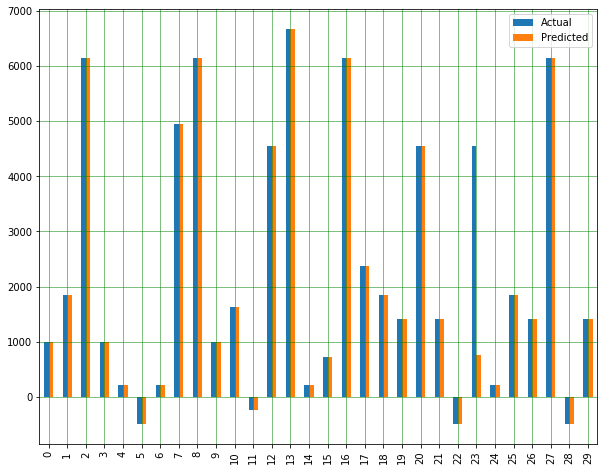

In [15]:
y_pred = regressaoLinear.predict(x_teste)
df = pd.DataFrame({'Actual': y_teste, 'Predicted': y_pred})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Decision Tree Regressor

In [16]:
from sklearn.tree import DecisionTreeRegressor

In [17]:
regressaoArvores = DecisionTreeRegressor(random_state = 0)
regressaoArvores.fit(x_treino, y_treino)
score = regressaoArvores.score(x_treino, y_treino)
previsoes = regressaoArvores.predict(x_teste)
mae = mean_absolute_error(y_teste, previsoes)
mse = mean_squared_error(y_teste, previsoes)

In [18]:
print('Decision Tree Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Score: " + str(score))

Decision Tree Regression
Mean absolute error: 12.30602864611467
Mean squared error: 5228.35479987686
Score: 1.0


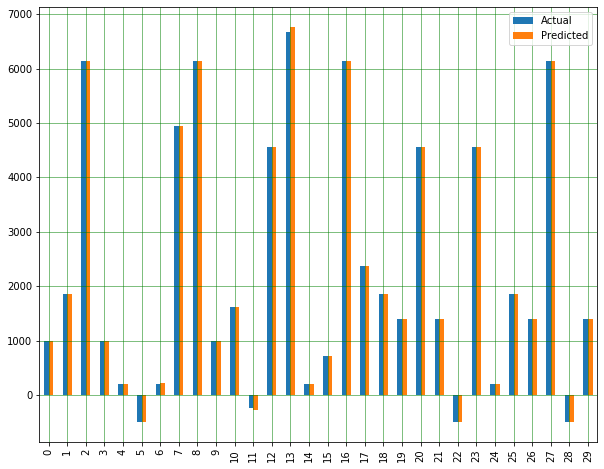

In [19]:
y_pred = regressaoArvores.predict(x_teste)
df = pd.DataFrame({'Actual': y_teste, 'Predicted': y_pred})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
regressaoRandomForest = RandomForestRegressor(n_estimators = 100)
regressaoRandomForest.fit(x_treino, y_treino)
score = regressaoRandomForest.score(x_treino, y_treino)
previsoes = regressaoRandomForest.predict(x_teste)
mae = mean_absolute_error(y_teste, previsoes)
mse = mean_squared_error(y_teste, previsoes)

In [22]:
print('Random Forest Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Score: " + str(score))

Random Forest Regression
Mean absolute error: 17.328127478622903
Mean squared error: 9902.76097013023
Score: 0.9998127955959927


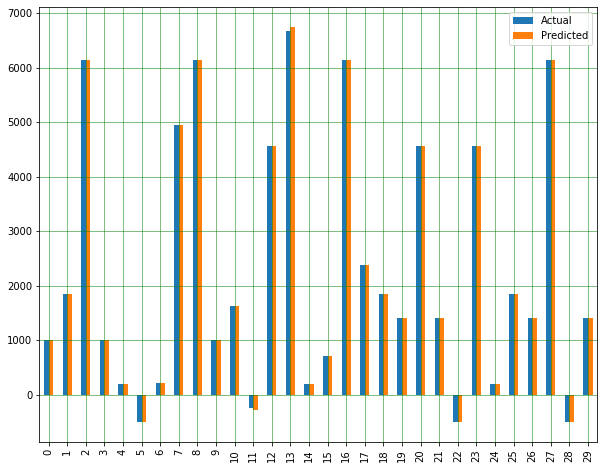

In [23]:
y_pred = regressaoRandomForest.predict(x_teste)
df = pd.DataFrame({'Actual': y_teste, 'Predicted': y_pred})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Support Vector Regression

In [24]:
from sklearn.svm import SVR

In [25]:
regressorSVM = SVR(kernel = 'rbf')
regressorSVM.fit(x_treino, y_treino)
score = regressorSVM.score(x_treino, y_treino)
previsoes = regressorSVM.predict(x_teste)
mae = mean_absolute_error(y_teste, previsoes)
mse = mean_squared_error(y_teste, previsoes)

In [26]:
print('SVR Regression')
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Score: " + str(score))

SVR Regression
Mean absolute error: 1699.7161183053422
Mean squared error: 6012925.459513245
Score: -0.1232121535867179


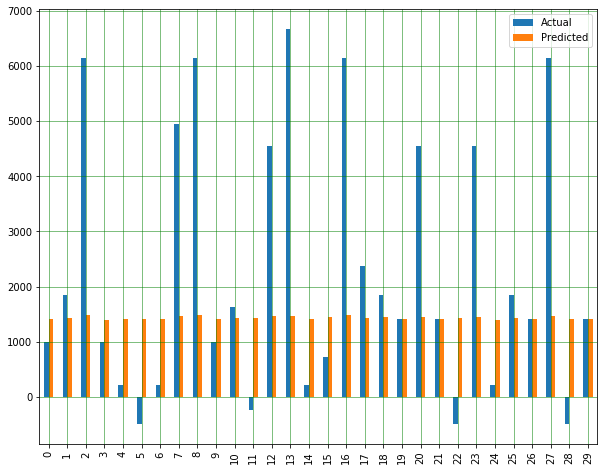

In [27]:
y_pred = regressorSVM.predict(x_teste)
df = pd.DataFrame({'Actual': y_teste, 'Predicted': y_pred})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Plot Todas as Regressões

In [28]:
params = {'legend.fontsize': 'large',          
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

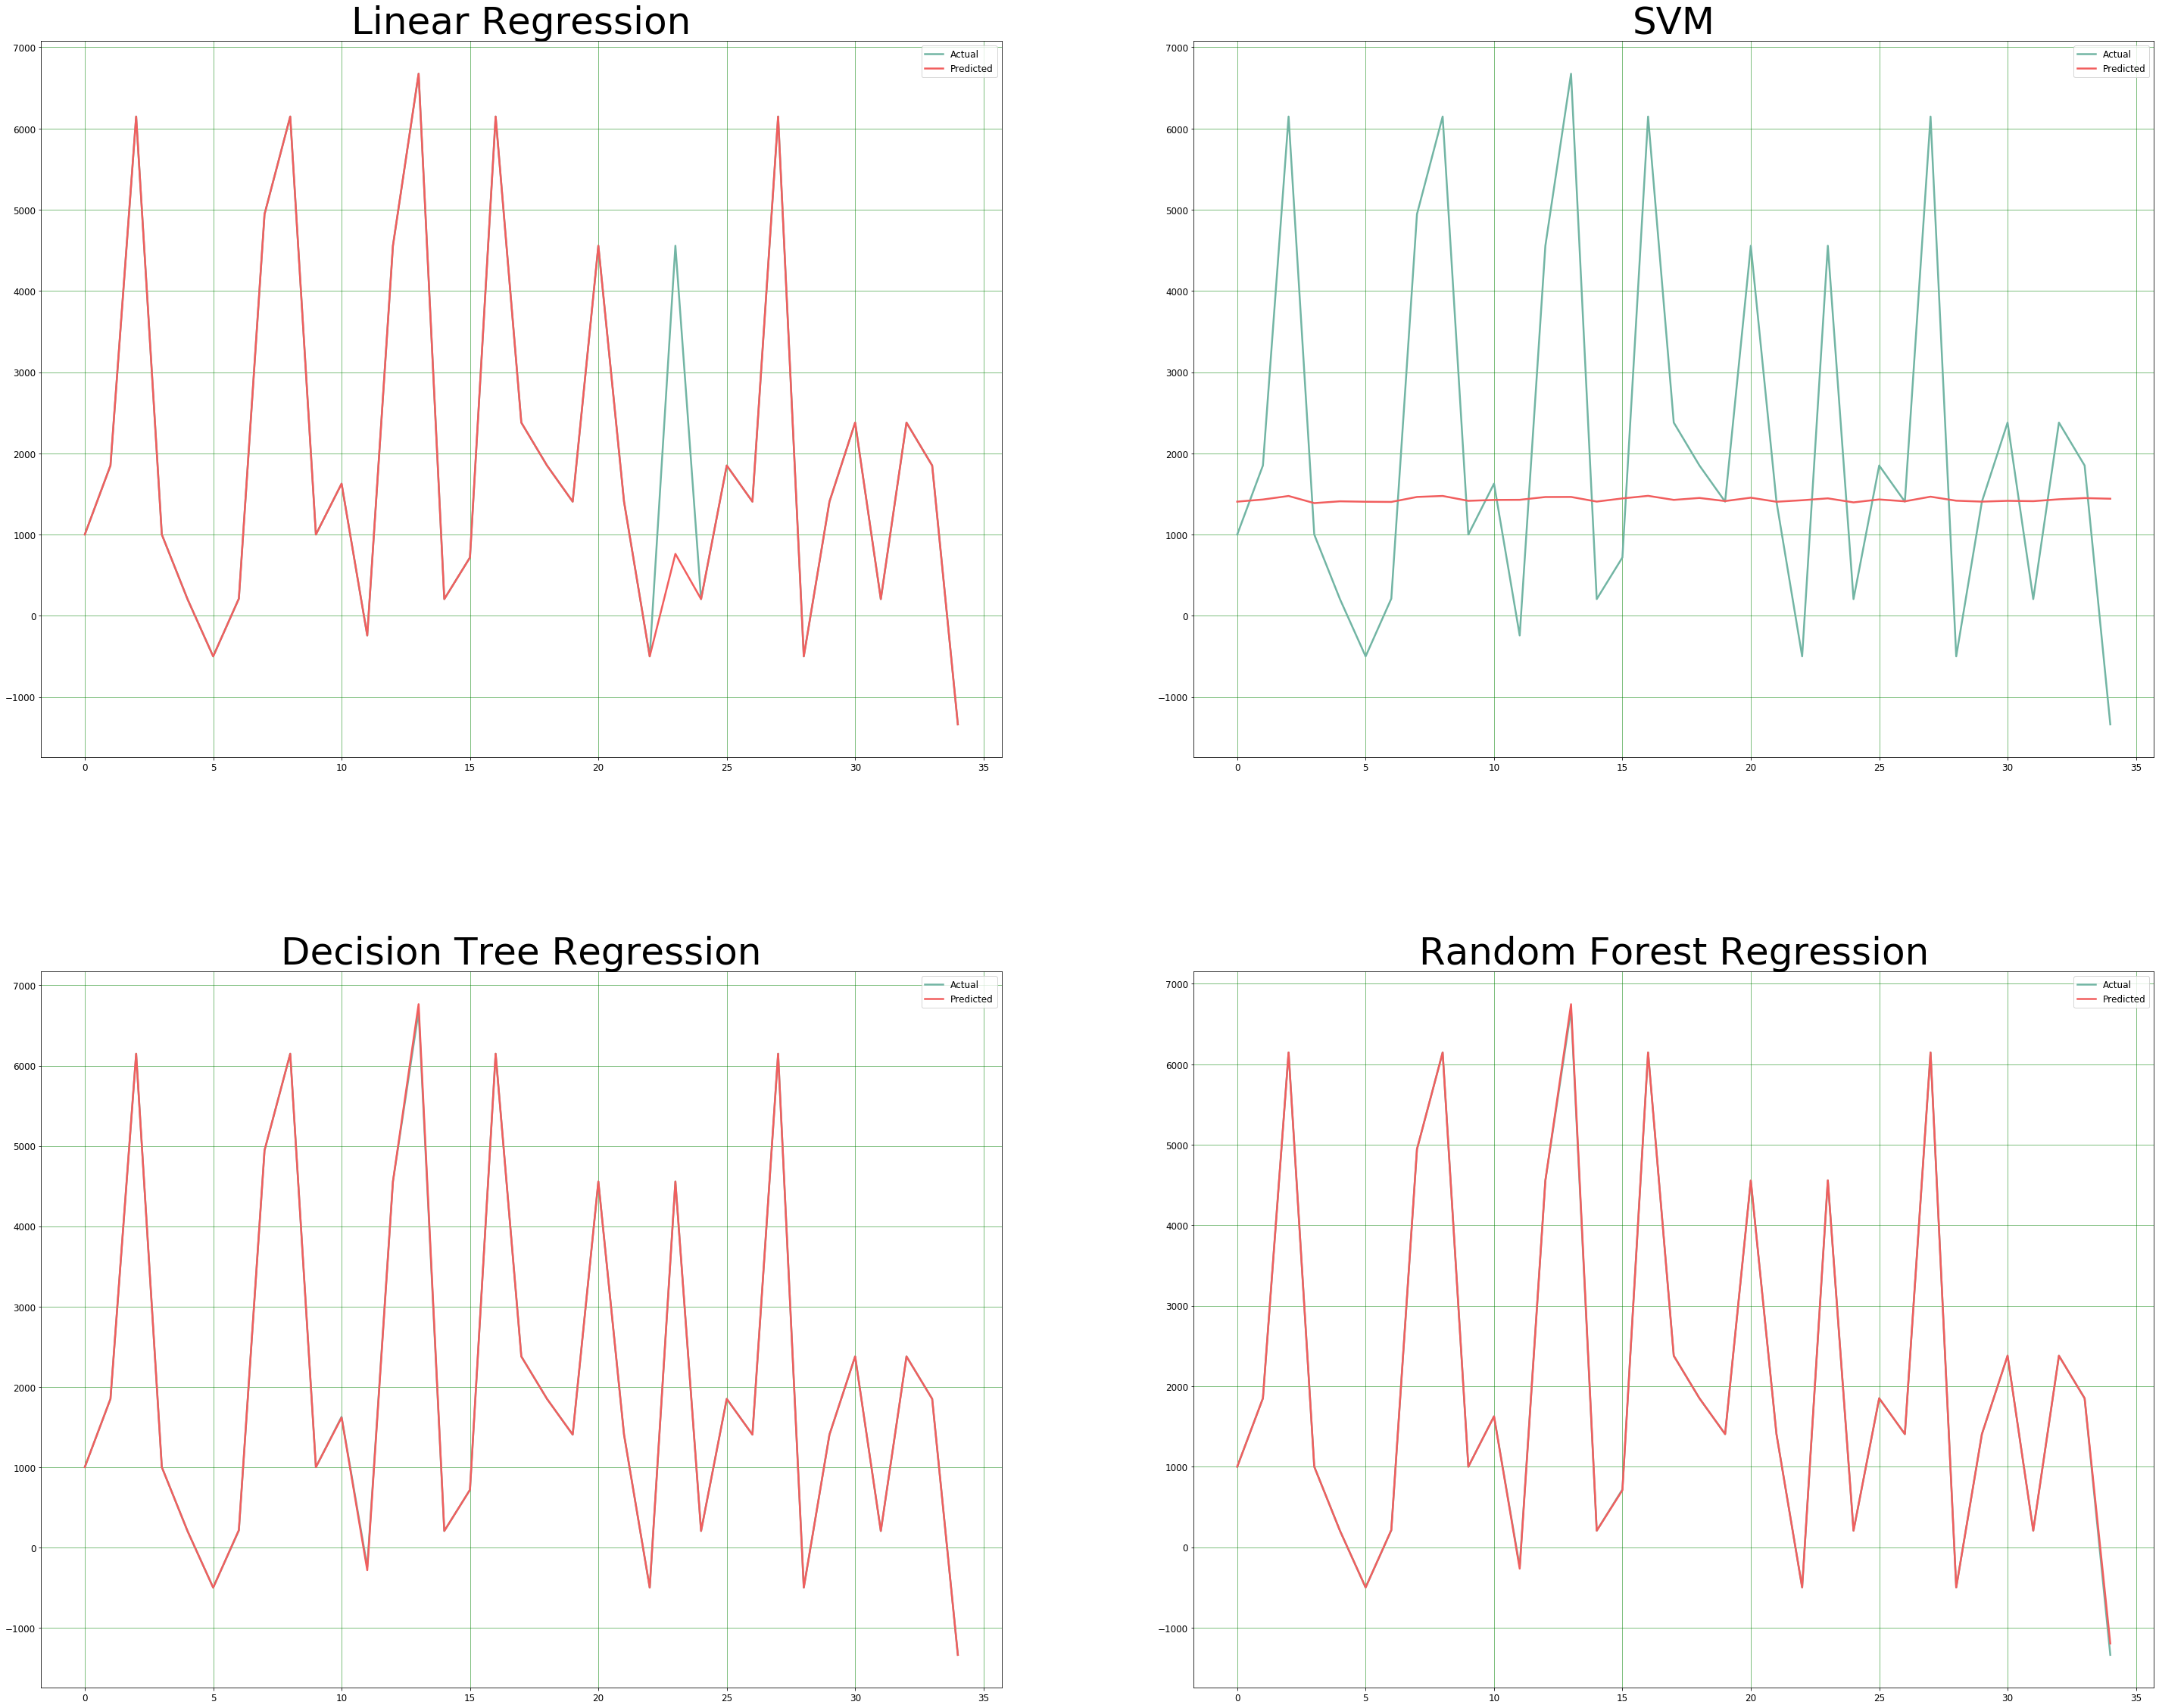

In [29]:
fig, eixos = plt.subplots(nrows=2, ncols=2, figsize=(50,40))

eixos[0,0].plot(pd.DataFrame({'x': y_teste}).head(35), linewidth='2.5', color = '#72B5A4', label='Actual')
eixos[0,0].plot(pd.DataFrame({'y': regressaoLinear.predict(x_teste)}).head(35), linewidth='2.5', color = '#F15E5E', label='Predicted')
eixos[0,0].set_title('Linear Regression', fontsize=50)
eixos[0,0].legend(loc="upper right")
eixos[0,0].grid(which='major', linestyle='-', linewidth='0.5', color='green')
eixos[0,0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

eixos[0,1].plot(pd.DataFrame({'x': y_teste}).head(35), linewidth='2.5', color = '#72B5A4', label='Actual')
eixos[0,1].plot(pd.DataFrame({'y': regressorSVM.predict(x_teste)}).head(35), linewidth='2.5', color = '#F15E5E', label='Predicted')
eixos[0,1].set_title('SVM', fontsize=50)
eixos[0,1].legend(loc="upper right")
eixos[0,1].grid(which='major', linestyle='-', linewidth='0.5', color='green')
eixos[0,1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

eixos[1,0].plot(pd.DataFrame({'x': y_teste}).head(35), linewidth='2.5', color = '#72B5A4', label='Actual')
eixos[1,0].plot(pd.DataFrame({'y': regressaoArvores.predict(x_teste)}).head(35), linewidth='2.5', color = '#F15E5E', label='Predicted')
eixos[1,0].set_title('Decision Tree Regression', fontsize=50)
eixos[1,0].legend(loc="upper right")
eixos[1,0].grid(which='major', linestyle='-', linewidth='0.5', color='green')
eixos[1,0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

eixos[1,1].plot(pd.DataFrame({'x': y_teste}).head(35), linewidth='2.5', color = '#72B5A4', label='Actual')
eixos[1,1].plot(pd.DataFrame({'y': regressaoRandomForest.predict(x_teste)}).head(35), linewidth='2.5', color = '#F15E5E', label='Predicted')
eixos[1,1].set_title('Random Forest Regression', fontsize=50)
eixos[1,1].legend(loc="upper right")
eixos[1,1].grid(which='major', linestyle='-', linewidth='0.5', color='green')
eixos[1,1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.3)
#plt.show()
plt.savefig('graphs.png')